# GPN-CUP

Для лучшего управления магазинами, в частности, для более оптимального планирования промо-кампаний и прогнозирования спроса, вам необходимо разбить магазины на кластеры похожих. Единственный способ, которым пользовалась компания в прошлом – это разбитие по географическому признаку, то есть по городам. Но вы верите, что прочие характеристики магазинов, а самое главное, профили продаж магазинов, помогут сделать это гораздо точнее.

<img src="img/mad_max.jpg" height=400px width=640px>

Итак, задача – провести кластерный анализ магазинов. В данной работе упор будет сделан на кластеризацию для прогнозирования продаж. Анализ будет проведён в несколько этапов:

    1) построение описательных статистик, изучение имеющихся данных.

    2) выделение основных факторов, влияющих на продажи.

    3) проведение кластерного анализа.

    4) построение примера прогнозной модели для кластеризированных данных. 

## Знакомство с данными

Прежде всего импортируем необходимые библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)

Данные о разбивке городов по локациям

In [3]:
cities = pd.read_parquet('cities.parquet')
cities.head()

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь


In [4]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   city      15 non-null     object
 1   location  15 non-null     object
dtypes: object(2)
memory usage: 368.0+ bytes


In [5]:
for loc in cities['location'].unique():
    print(loc)

Скалистый Могильник
Свистящие Степи
Радиоактивная Пустошь


Итак, всего имеется 15 городов, расположенных в трёх локациях. 

<img src="img/map.jpg" height=400px width=711px>

Также имеются данные о продажах

In [6]:
sales = pd.read_parquet('sales.parquet')
sales.head(7)

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0
5,2146-01-01,1,Рейдеры,5,Броня и одежда,2.0
6,2146-01-01,1,Рейдеры,5,Бензак,5510.0


In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5081459 entries, 0 to 5081458
Data columns (total 6 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   shop_id             int64         
 2   owner               object        
 3   number_of_counters  int32         
 4   goods_type          object        
 5   total_items_sold    float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2)
memory usage: 213.2+ MB


In [8]:
sales['shop_id'].unique().shape

(845,)

В нашем располряжении пять миллионов записей о продажах, накопленные за два года в 845 магазинах. Посмотрим, как записи о продажах разделились по владельцам магазинов. 

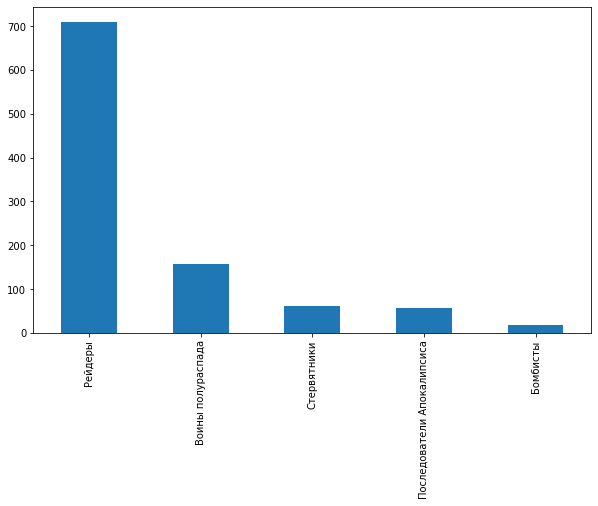

In [9]:
sales_owner = sales[['owner', 'shop_id']].drop_duplicates()
sales_owner['owner'].value_counts().plot.bar()
plt.show()

In [10]:
sales_owner.shape

(1002, 2)

In [11]:
sales_owner.groupby(by=['shop_id']).count().max()

owner    2
dtype: int64

Большинство магазинов принадлежат рейдерам. Отметим также, что всего магазинов 845, а уникальных записей в таблице "владелец", "магазин" – 1002, что означает, что с течением времени магазины меняли владельцев, но не более одного раза. Посмотрим теперь на продажи различных товаров. 

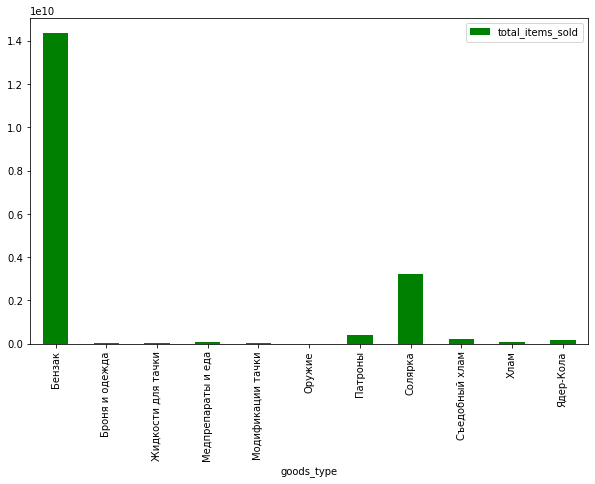

In [12]:
sales_mean_items_sold = sales[['goods_type', 'total_items_sold']].groupby(by=['goods_type']).sum()
sales_mean_items_sold.plot.bar(color='green')
plt.show()

In [13]:
sales_mean_items_sold.shape

(11, 1)

Всего 11 различных типов товаров. Наиболее востребованными являются бензак и солярка. Количество проданного товара этих типов *значительно* превосходит продажи товаров других типов. Посмотрим на распределение (гистограммы) продаж товара каждого типа. 

In [14]:
goods_types = sales_mean_items_sold.index.to_list()

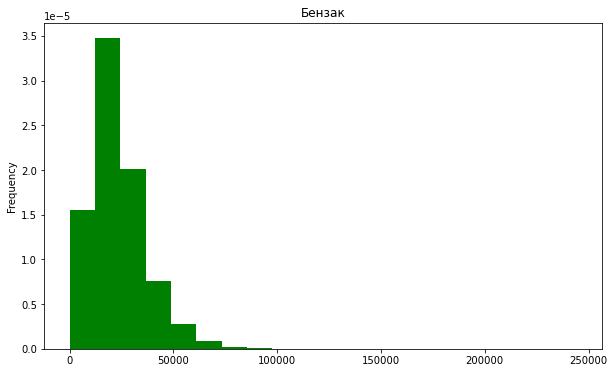

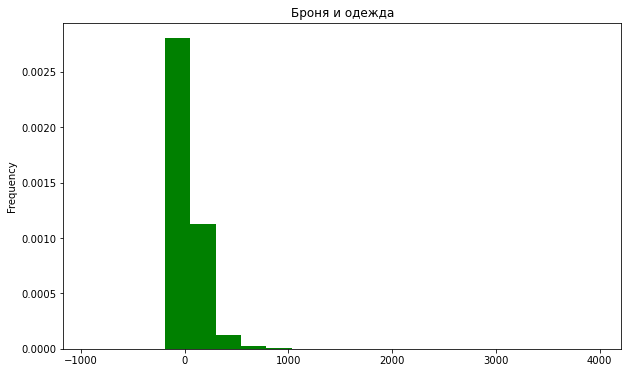

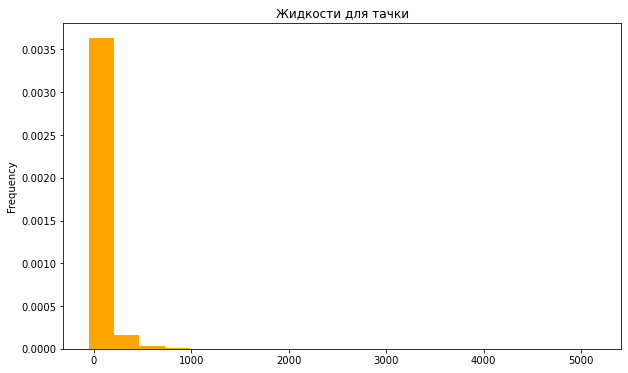

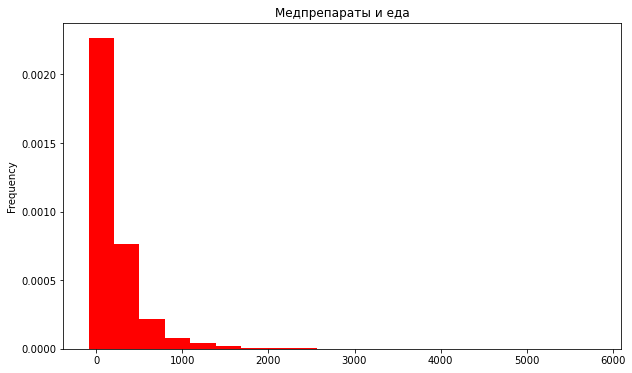

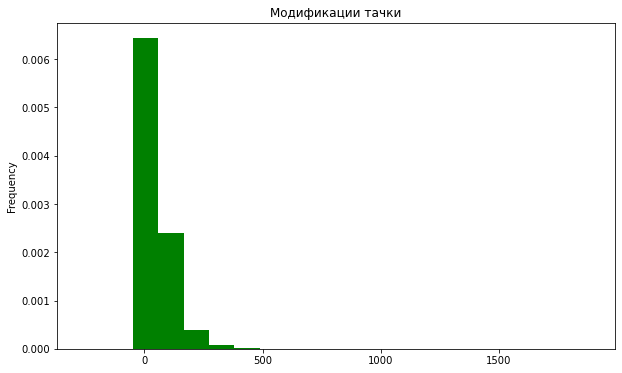

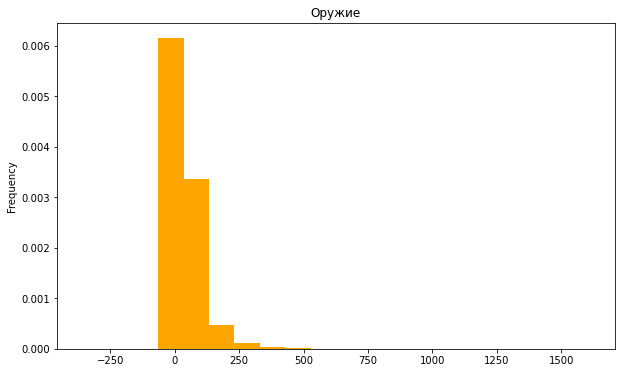

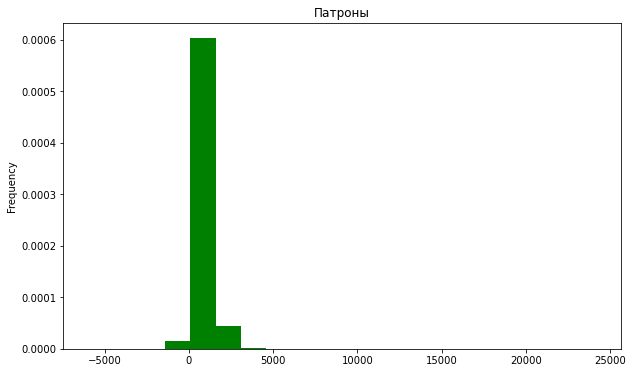

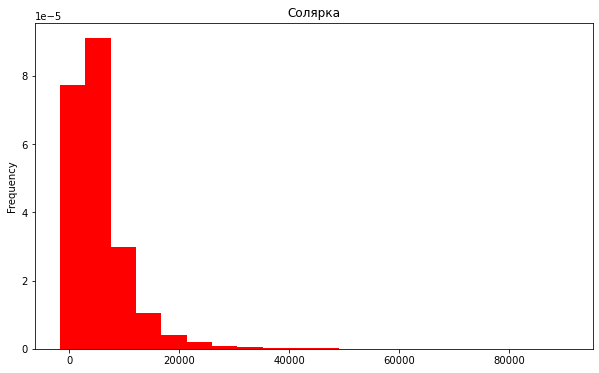

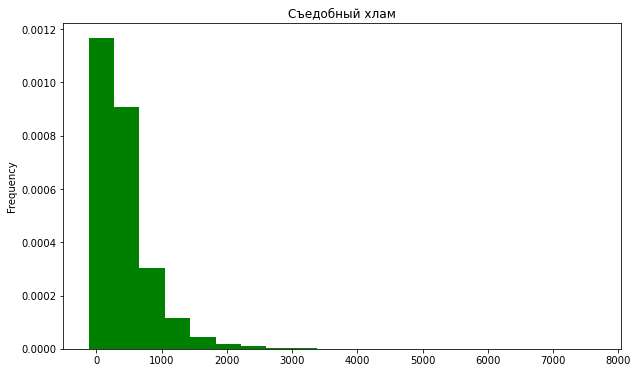

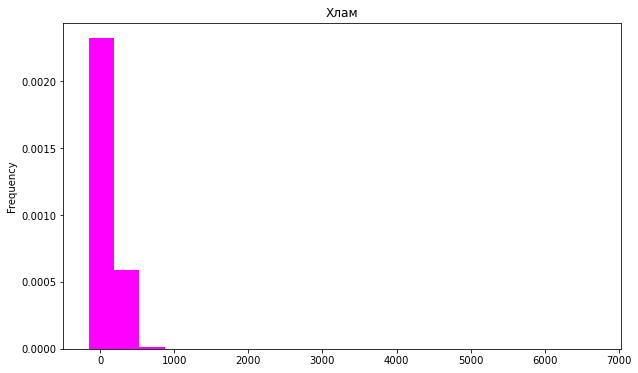

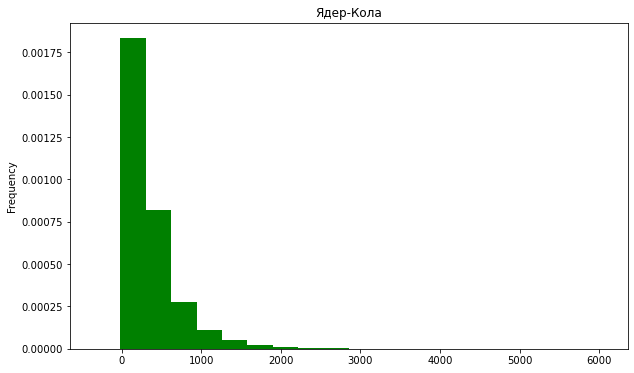

In [15]:
for goods_type in goods_types:
    sales['total_items_sold'][sales['goods_type'] == goods_type].plot.hist(bins=20, 
                                                                           density=True,
                                                                           color=np.random.choice([
                                                                               'red', 
                                                                               'orange', 
                                                                               'blue', 
                                                                               'green', 
                                                                               'magenta']))
    plt.title(goods_type)
    plt.show()

Напоминает скорее пуассоновское распределение. Хотя меня радует наличие "отрицательных" продаж, т.е. магазины в состоянии не только продавать, но и покупать (отбирать?) товары. 

In [16]:
int(5081459 / sales[sales['total_items_sold'] < 0].shape[0])

4933

К счастью, это не самый частый случай (1 к 4933) и его можно игнорировать (считать выбросом).

Теоретически магазины могут быть специализироваться или не специализироваться на продаже конкретного товара. Посчитаем, сколько различных товаров продаётся в магазинах. 

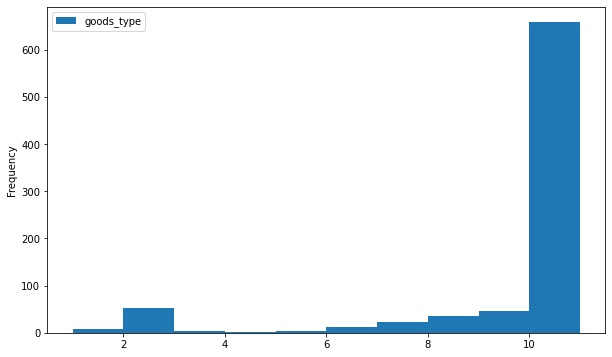

In [17]:
sales[['shop_id', 'goods_type']].drop_duplicates().groupby(by=['shop_id']).count().plot.hist()
plt.show()

Во многих магазинах в продаже имеются все типы товаров, но есть и исключения, и их немало. Перейдём к рассмотрению магазинов. 

In [18]:
shops = pd.read_parquet('shops.parquet')
shops.head(7)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2
5,823,У воды,Газтаун,-1,нет,None,None,1
6,214,В центре,Пасть,2130,нет,нет,нет,1


In [19]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   shop_id                      845 non-null    int32 
 1   neighborhood                 845 non-null    object
 2   city                         788 non-null    object
 3   year_opened                  845 non-null    int32 
 4   is_on_the_road               838 non-null    object
 5   is_with_the_well             785 non-null    object
 6   is_with_additional_services  784 non-null    object
 7   shop_type                    713 non-null    object
dtypes: int32(2), object(6)
memory usage: 46.3+ KB


Записи есть обо всех магазинах. Часть данных пропушена. Посмотрим на распределение магазинов по городам. 

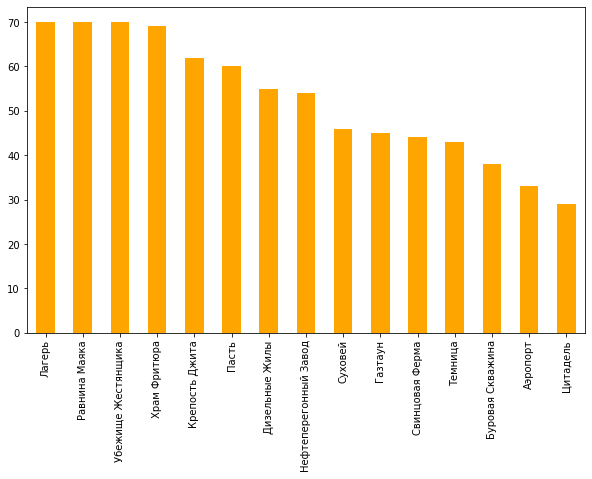

In [20]:
shops['city'].value_counts().plot.bar(color='orange')
plt.show()

Количество магазинов варьируется от 29 до 70, в среднем 53 магазина в городе. 

## Выделение основных факторов

### Описание модели

Каждой паре `(shop_id, goods_type)` соответствует своя динамика (временной ряд) продаж. ***Ключевая идея работы состоит в том, чтобы разбить магазины на кластеры по схожести динамики продаж***. Внутри каждого кластера временные ряды должны быть похожи, а временные ряды разных кластеров различны. Для каждого типа товара будет построена своя кластеризация.

В каждом кластере будет построен временной ряд продаж, усредняющий значения всех остальных временных рядов. Для этого временного ряда будет построена модель `SARIMAX` (с учётом пуассоновского распределения целевой переменной). Таким образом, чтобы получить прогноз продаж конкретного товара в конкретном магазине, необходимо спрогнозировать усредняющий временной ряд и домножить прогноз на корректирующий коэффициент магазина.

### Подготовка данных для кластеризации

Для кластеризации необходимо построить таблицы для каждого типа товара: имена строк – `date`, имена столбцов – `shop_id`, на пересечении – `total_items_sold`. 

In [21]:
from tqdm import tqdm #индикатор прогресса

In [22]:
data = sales.drop(columns=['owner', 'number_of_counters']).groupby(by=['goods_type', 'shop_id', 'date']).max()
data.head()

total_items_sold
goods_type shop_id date                        
Бензак     0       2146-01-01           10537.0
                   2146-01-02           14107.0
                   2146-01-03           16092.0
                   2146-01-04           18050.0
                   2146-01-05           18456.0

In [23]:
goods_types = sales['goods_type'].unique()
for goods_type in tqdm(goods_types):
    data_goods_type = data.loc[goods_type].unstack().transpose()
    data_goods_type.index = data_goods_type.index.to_frame().date.values
    data_goods_type.columns.name = None
#     data_goods_type.sort_index().to_csv(goods_type + '.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.35it/s]


Указанные таблицы созданы и сохранены в формате `CSV`. 

### Подготовка данных для прогнозирования

Следующий этап состоит в подготовке таблицы для прогнозной модели. Построение модели `SARIMAX` в нашем случае можно разделить на два этапа. Первый этап: построение пуассоновской регрессии продаж по факторам в виде

$$y_i = \exp \left( \sum \limits_{i = 1}^m {\theta_j x_{ji}} \right) + \varepsilon_i$$

где $y$ (`total_items_sold`) имеет пуассоновское распределение. Факторами $x_j$ будут выступать `neighborhood`, `city`, `location`, `is_on_the_road`, `is_with_the_well`, `is_with_additional_services`, `shop_type`, `owner` и `number_of_counters`. Остатки пуассоновской регрессии $\varepsilon$ приближаются моделью `SARIMA` (англ. *Seasonal AutoRegressive Integrated Moving Average*). 

Большинство перечисленных признаков относятся к фиктивным переменным, они будут закодированы методом *one hot encoding*. Кроме того, по некоторым признакам для некоторых магазинов содержатся пропуски. Данные факторы предположительно оказывают *положительное* влияние на динамику продаж. Это кажется логичным, потому что если расположение рядом с дорогой, наличие колодца и прочие дополнительные сервисы не увеличивают продажи, то логично не строить магазины у дорог, зарыть колодцы и т. д. Именно поэтому по данным факторам в таблице пропуски будут заполнены нулями.

Посмотрим, сколько пропущено значений в каждом столбце.

In [24]:
from sklearn.preprocessing import OneHotEncoder

In [25]:
n = len(shops)
for col in shops.columns:
    print('В столбце ' + col + ' пропущено', n - shops[col].dropna().shape[0], 'значений.')

В столбце shop_id пропущено 0 значений.
В столбце neighborhood пропущено 0 значений.
В столбце city пропущено 57 значений.
В столбце year_opened пропущено 0 значений.
В столбце is_on_the_road пропущено 7 значений.
В столбце is_with_the_well пропущено 60 значений.
В столбце is_with_additional_services пропущено 61 значений.
В столбце shop_type пропущено 132 значений.


Заполнаяем пропуски, дополняем информацию о локации

In [26]:
values = {'city' : 'Неизвестно', 
          'location' : 'Неизвестно', 
          'is_on_the_road' : 'нет', 
          'is_with_the_well' : 'нет', 
          'is_with_additional_services' : 'нет', 
          'shop_type' : '0'}
shops = shops.merge(cities, on='city', how='left').drop(columns='year_opened').fillna(value=values)
shops.head()

,shop_id,neighborhood,city,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,location
0,705,В центре,Крепость Джита,нет,да,да,1,Скалистый Могильник
1,601,В центре,Суховей,нет,нет,нет,4,Скалистый Могильник
2,530,В центре,Храм Фритюра,нет,нет,нет,0,Скалистый Могильник
3,91,В центре,Убежище Жестянщика,нет,нет,да,1,Свистящие Степи
4,100,На отшибе,Убежище Жестянщика,да,нет,да,2,Свистящие Степи


In [27]:
X = OneHotEncoder(sparse=False).fit_transform(shops.drop(columns='shop_id').values)

In [28]:
encoded_shops = pd.DataFrame(X, columns=['x' + str(i) for i in range(X.shape[1])], dtype=np.int64)
encoded_shops.index = shops['shop_id']
encoded_shops = encoded_shops.sort_index()
encoded_shops.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37
shop_id,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


Сохраняем промежуточный результат для проведения кластеризации по факторам. 

In [29]:
# encoded_shops.to_csv('encoded_shops.csv')

Составляем общую базу данных. Кодированию в данной базе не подлежат столбцы `date` и `number_of_counters`. Столбец `total_items_sold` является целевой переменной, поэтому также будет удалён. В дальнейшем подлежит разбиение по магазинам и товарам, поэтому данная информация так же удаляется при кодировании

In [30]:
data = sales.merge(shops, how='left', on='shop_id')
data.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold,neighborhood,city,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,location
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0,В центре,Нефтеперегонный Завод,нет,нет,нет,0,Свистящие Степи
1,2146-01-01,0,Рейдеры,4,Хлам,26.0,В центре,Нефтеперегонный Завод,нет,нет,нет,0,Свистящие Степи
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0,В центре,Нефтеперегонный Завод,нет,нет,нет,0,Свистящие Степи
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0,В центре,Нефтеперегонный Завод,нет,нет,нет,0,Свистящие Степи
4,2146-01-01,1,Рейдеры,5,Хлам,9.0,В центре,Нефтеперегонный Завод,нет,нет,нет,0,Свистящие Степи


Применяем `OneHotEncoder` из `sklearn`. 

In [31]:
delete = ['date', 'shop_id', 'number_of_counters', 'goods_type', 'total_items_sold']
X = OneHotEncoder(sparse=False).fit_transform(data.drop(columns=delete).values)
X.shape

(5081459, 43)

Присоединяем оставшиеся признаки и целевую переменную. Строим `pandas.DataFrame` с исходными датами. 

In [32]:
dataX = pd.DataFrame(np.hstack((data[['number_of_counters']].values, X)), 
                     columns=['x' + str(i) for i in range(1, 45)])

cols = ['date', 'shop_id', 'goods_type']
dataX[cols] = data[cols]
dataX['y'] = data['total_items_sold']
dataX.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x39,x40,x41,x42,x43,x44,date,shop_id,goods_type,y
0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,0,Съедобный хлам,6.0
1,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,0,Хлам,26.0
2,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,0,Бензак,10537.0
3,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,1,Съедобный хлам,17.0
4,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,1,Хлам,9.0


Экспортируем результат в `PARQUET`

In [33]:
# dataX.to_parquet('forecast_data.parquet')